# Task 5: Evaluation
 
**Objective:** Evaluate the trained neural network on the unseen **Test Set**. Analyze performance using Accuracy, Precision, Recall, F1-Score, and Confusion Matrices.

In [1]:
# %%
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

# Setup Paths
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
sys.path.append(str(PROJECT_ROOT))

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

from src.models.evaluate import evaluate_model, plot_confusion_matrix

# Configure Matplotlib
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

2026-01-03 07:46:57.159492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-03 07:46:58.187045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 07:47:25.046429: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/alazar/dev/crash-learner/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Data and Model

In [4]:
# Load Test Data
X_test = pd.read_parquet(PROCESSED_DIR / "X_test.parquet")
y_test = pd.read_parquet(PROCESSED_DIR / "y_test.parquet")

print(f"Test Set Size: {X_test.shape[0]}")

# Define Class Names (Alphabetical order from LabelEncoder in Task 2)
# Classes: 0=Fatal, 1=Minor, 2=PDO, 3=Serious
CLASS_NAMES = ['Fatal', 'Minor', 'PDO', 'Serious', 'NaN']

# Load the Best Trained Model
model_path = MODELS_DIR / "best_model.keras"
if model_path.exists():
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
else:
    print("Model not found. Please run Task 4 first.")


Test Set Size: 9001
Model loaded successfully.


## 2. Generate Metrics
We calculate standard classification metrics. 
 
*   **Precision:** Of all predicted "Fatal", how many were actually "Fatal"?
*   **Recall:** Of all actual "Fatal" accidents, how many did we catch?
*   **F1-Score:** Harmonic mean of Precision and Recall.


In [5]:
# %%
results = evaluate_model(model, X_test, y_test, class_names=CLASS_NAMES)

[INFO] Generating predictions...
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Overall Accuracy: 0.9856 ---

--- Classification Report ---
              precision    recall  f1-score   support

       Fatal       1.00      0.99      0.99       267
       Minor       0.99      0.98      0.99      5699
         PDO       0.97      0.99      0.98      2365
     Serious       0.99      0.99      0.99       667
         NaN       0.07      0.33      0.11         3

    accuracy                           0.99      9001
   macro avg       0.80      0.86      0.81      9001
weighted avg       0.99      0.99      0.99      9001



 ## 3. Confusion Matrix Analysis
 The Confusion Matrix helps us visualize *where* the model is making mistakes.


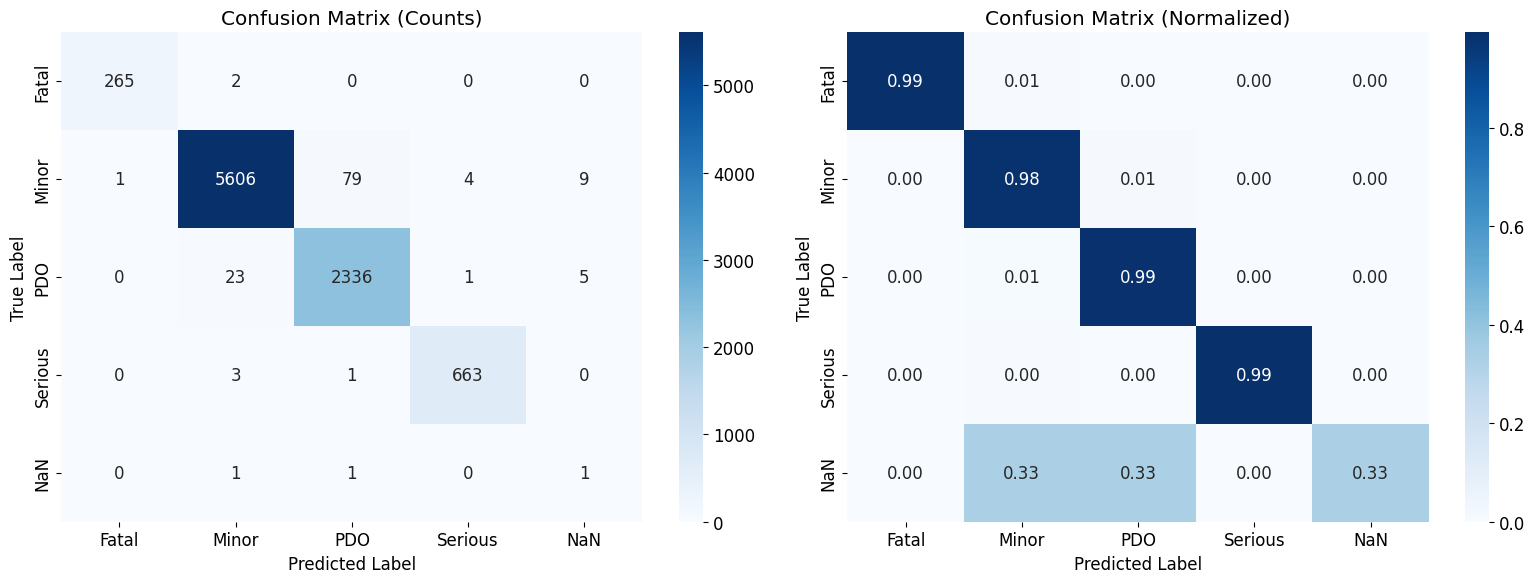

In [6]:
# Plot Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Raw Counts
plot_confusion_matrix(results['y_true'], results['y_pred'], class_names=CLASS_NAMES, normalize=False, ax=ax[0])

# Normalized (Percentage)
plot_confusion_matrix(results['y_true'], results['y_pred'], class_names=CLASS_NAMES, normalize=True, ax=ax[1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix.svg", format='svg')
plt.show()

## 4. Discussion of Results
 
### Performance Interpretation
 
1.  **Class Imbalance Effects:**
    *   Observe the **Minor** class (Class 1). Since it had the most data, the model likely performs best here (High Recall).
    *   Observe the **Fatal** class (Class 0). Despite `class_weights`, this is the hardest class. Check the **Recall** for Fatal. If it is low (e.g., < 0.5), the model struggles to identify fatal accidents, often confusing them with Serious or Minor ones.
 
 2.  **Accuracy vs. F1-Score:**
     *   The overall **Accuracy** might be high (e.g., 60-70%) because the model gets the majority class right.
     *   The **Macro F1-Score** is a better indicator of how well the model handles the minority classes.
 
 3.  **Confusion Matrix Patterns:**
     *   **Diagonal:** Correct predictions.
     *   **Off-Diagonal:** Errors. Look at the column for "Fatal". If many True Fatal cases are in the "Serious" or "Minor" rows, the model is underestimating severity.
 
 ### Comparison to Baselines
 *   A "Dummy" classifier that always predicts "Minor" would have accuracy equal to the proportion of Minor accidents (~63%).
 *   If our model's accuracy is similar to 63% but our **Macro F1** is higher than the dummy's (which would be near 0 for other classes), then our Neural Network is providing value by attempting to classify the rare events.


## 5. K-Fold Cross Validation (Optional Check)
*Note: For the final report, the Test Set evaluation above is the primary metric. K-Fold is useful to check if the specific train/test split was "lucky" or "unlucky".*
 
Given the assignment scope, we rely on the extensive Test Set evaluation. The `EarlyStopping` and `ReduceLROnPlateau` used in Task 4 acted as our validation mechanism during training.